## Environment Setup

In [10]:
## Ensure TensorFlow is not used
import os
os.environ["USE_TF"] = "0"

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
from transformers import CLIPModel, BertModel, BertTokenizer, CLIPTokenizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import os
import sys
import pandas as pd
import numpy as np
import torch
import sys
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import textwrap


B = 32 # batch size from training

device = torch.device("mps")

## Load Data & Setup Dataloaders

In [11]:
DATA_DIR = "../../../cleaned_data"

TRAIN_DATA_FILE = os.path.join(DATA_DIR, "train.csv")
VALIDATION_DATA_FILE = os.path.join(DATA_DIR, "validation_5k.csv")
TEST_DATA_FILE = os.path.join(DATA_DIR, "test_5k.csv")

TRAIN_DATA = pd.read_csv(TRAIN_DATA_FILE)
VALIDATION_DATA = pd.read_csv(VALIDATION_DATA_FILE, index_col = 0)
TEST_DATA = pd.read_csv(TEST_DATA_FILE, index_col = 0)


# Ignore rows in corrupted_indices.txt files
def filter_out_corrupted_rows(split, DF):
    # File with corrupted indices
    if split == "train":
        corrupted_indices_file = f"../../../cleaned_data/{split}_corrupted_indices.txt"
    else:
        corrupted_indices_file = f"../../../cleaned_data/{split}_5k_corrupted_indices.txt"

    # Store list of corrupted indices
    corrupted_indices = None

    # Get list of corrupted indices
    with open(corrupted_indices_file, "r") as f:
        corrupted_indices = list(int(line.strip()) for line in f if line.strip())

    print(f"Split: {split}, Corrupted Indices: {corrupted_indices}, Length: {len(corrupted_indices)}")

    # Filter out corrupted rows
    DF = DF.drop(index = corrupted_indices)

    return DF



TRAIN_DATA = filter_out_corrupted_rows("train", TRAIN_DATA)
VALIDATION_DATA = filter_out_corrupted_rows("validation", VALIDATION_DATA)
TEST_DATA = filter_out_corrupted_rows("test", TEST_DATA)


TRAIN_DATA['image_num'] = TRAIN_DATA.index.astype(str).str.zfill(5)
VALIDATION_DATA['image_num'] = VALIDATION_DATA.index.astype(str).str.zfill(5)
TEST_DATA['image_num'] = TEST_DATA.index.astype(str).str.zfill(5)


Split: train, Corrupted Indices: [2862, 26040, 28337, 18547, 13374, 11288, 31984, 18451, 19000, 22479, 8048, 32075, 22918, 5586, 19345, 12770, 32189, 14628, 9081, 6611, 2927], Length: 21
Split: validation, Corrupted Indices: [6568, 32176], Length: 2
Split: test, Corrupted Indices: [29133, 9437, 26504, 11394], Length: 4


In [12]:
class RedditDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Fetch text
        text = row['clean_title']

        # Get image number
        image_num = row['image_num']

        # Fetch Image
        img_path = f"../../../{self.image_dir}/{image_num}.jpg"
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Label
        label = torch.tensor(row['2_way_label'], dtype=torch.long)

        return text, image, label


train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])



def collate_fn(batch):
    texts, images, labels = zip(*batch)
    images = torch.stack(images)
    labels = torch.stack(labels)
    return list(texts), images, labels



train_dataset = RedditDataset(
    df = TRAIN_DATA,
    image_dir = "train_images",
    transform = train_tfms
)

validation_dataset = RedditDataset(
    df = VALIDATION_DATA,
    image_dir = "validation_images",
    transform = val_test_tfms
)

test_dataset = RedditDataset(
    df = TEST_DATA,
    image_dir = "test_images",
    transform = val_test_tfms
)



train_loader = DataLoader(
    train_dataset,
    batch_size=B,
    shuffle=True,
    collate_fn=collate_fn
)

validation_loader = DataLoader(
    validation_dataset,
    batch_size=B,
    shuffle=False,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=B,
    shuffle=False,
    collate_fn=collate_fn
)

## QKV Attention Model Setup

In [13]:
## Ensure TensorFlow is not used
import os
os.environ["USE_TF"] = "0"

# Import necessary software
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models as tv_models
from transformers import CLIPModel, BertModel, BertTokenizer, CLIPTokenizer

# Use CPU/MPS if possible
import sys
device = None
if "google.colab" in sys.modules:
    # Running in Colab
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
else:
    # Not in Colab (e.g., Mac)
    device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

print("Using device:", device)

# Projection Head: 2-layer MLP (Reference: Page 4, Figure 2 of Paper)
class ProjectionHead(nn.Module):
    # in_dim: Number of input features to the Projection Head
    # hidden_dim: Size of hidden state representation
    # out_dim: Size of output dimension
    # dropout: dropout rate
    def __init__(self, in_dim, hidden_dim=256, out_dim=64, dropout=0.2):
        super().__init__()

        # Sequence 1: FC -> BN -> ReLU
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()

        # Define Dropout
        self.dropout = nn.Dropout(dropout)

        # Sequence 2: FC -> BN -> ReLU
        self.fc2 = nn.Linear(hidden_dim, out_dim)
        self.bn2 = nn.BatchNorm1d(out_dim)

    # Input Shape: (B, D) where B is batch size and D is in_dim
    def forward(self, x):
        # Sequence 1: FC -> BN -> ReLU
        x = self.fc1(x) # Shape: B x hidden_dim
        x = self.relu(x) # Shape: B x hidden_dim
        x = self.bn1(x) # Shape: B x hidden_dim

        # Dropout
        x = self.dropout(x) # Shape: B x hidden_dim

        # Sequence 2: FC -> BN -> ReLU
        x = self.fc2(x) # Shape: B x out_dim
        x = self.relu(x) # Shape: B x out_dim
        x = self.bn2(x) # Shape: B x out_dim

        # Return Output
        return x # Shape: B x out_dim

class QKVAttention(nn.Module):
    def __init__(self, feat_dim, num_heads=1, qkv_dim=16):
        super().__init__()

        self.feat_dim = feat_dim
        self.qkv_dim = qkv_dim
        self.num_heads = num_heads

        # Project 64 → 16
        self.q_proj = nn.Linear(feat_dim, qkv_dim)
        self.k_proj = nn.Linear(feat_dim, qkv_dim)
        self.v_proj = nn.Linear(feat_dim, qkv_dim)

        # Multihead attention
        self.attn = nn.MultiheadAttention(
            embed_dim=qkv_dim,
            num_heads=num_heads,
            batch_first=True
        )

        # Back to 64-dim
        self.out_proj = nn.Linear(qkv_dim, feat_dim)

    def forward(self, m_txt, m_img, m_mix, return_attention=False):
        x = torch.stack([m_txt, m_img, m_mix], dim=1)  # (B, 3, 64)

        Q = self.q_proj(x)
        K = self.k_proj(x)
        V = self.v_proj(x)

        # returns (B, heads, 3, 3)
        out, attn_weights = self.attn(
            Q, K, V,
            need_weights=True,
            average_attn_weights=False
        )

        mAgg = out.mean(dim=1)
        mAgg = self.out_proj(mAgg)

        if return_attention:
            return mAgg, attn_weights  # already correct shape
        return mAgg



# Define Final Classification Head
class ClassificationHead(nn.Module):
    # in_dim: Number of input features to the Classification Head
    # hidden_dim: Size of hidden state representation
    # out_dim: Size of output dimension
    def __init__(self, in_dim, hidden_dim = 64, out_dim = 2):
        super().__init__()

        # Sequence 1: FC -> ReLU
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.relu = nn.ReLU()

        # Sequence 2: FC
        self.fc2 = nn.Linear(hidden_dim, out_dim)

    # Shape of x: B(batch size) x d(# of features)
    def forward(self, x):
        # Pass through first layer
        x = self.relu(self.fc1(x))

        # Pass through second layer
        x = self.fc2(x)

        # Return output
        return x

# Fake News Detection(FND) CLIP Model
class FND_CLIP(nn.Module):
    # resnet_model_name: Name of resnet model
    # clip_model_name: Name of CLIP model
    # bert_model_name: Name of BERT Model
    def __init__(
        self,
        resnet_model_name = "resnet101",
        clip_model_name='openai/clip-vit-base-patch32',
        bert_model_name='bert-base-uncased',
        proj_hidden=256,
        proj_out=64,
        classifier_hidden=64,
        dropout=0.2,
        momentum=0.1
    ):
        super().__init__()

        # Sanity Check
        assert resnet_model_name == "resnet101"

        # 1. Setup ResNet Image Encoder
        # Replace the final fully connected layer with Identity because we only need the ResNet feature embeddings.
        self.image_encoder = tv_models.resnet101(weights='IMAGENET1K_V1')
        self.image_encoder.fc = nn.Identity()

        # Sanity Check: Assert that ResNet parameters are going to be fine tuned
        for param in self.image_encoder.parameters():
            assert param.requires_grad == True

        # 2. Setup BERT Text Encoder
        self.text_encoder = BertModel.from_pretrained(bert_model_name)
        self.text_encoder_tokenizer = BertTokenizer.from_pretrained(bert_model_name)

        # Freeze BERT weights
        for param in self.text_encoder.parameters():
            param.requires_grad = False

        # 3. Setup Multimodal (Text + Image) Encoder
        self.multimodal_encoder = CLIPModel.from_pretrained(clip_model_name)
        self.multimodal_encoder_tokenizer = CLIPTokenizer.from_pretrained(clip_model_name)

        # Freeze CLIP weights
        for param in self.multimodal_encoder.parameters():
            param.requires_grad = False

        # 4. Set up Text Projection Head
        self.pTxt = ProjectionHead(in_dim = 1280, hidden_dim = proj_hidden, out_dim = proj_out, dropout = dropout)
        self.pImg = ProjectionHead(in_dim = 2560, hidden_dim = proj_hidden, out_dim = proj_out, dropout = dropout)
        self.pMix = ProjectionHead(in_dim = 1024, hidden_dim = proj_hidden, out_dim = proj_out, dropout = dropout)

        # 5. Set up Modality-Wise Attention
        self.attention = QKVAttention(feat_dim = proj_out, num_heads = 2)

        # 6. Set up Final Classification Head
        self.classification_head = ClassificationHead(in_dim = proj_out, hidden_dim = classifier_hidden, out_dim = 2)

        # Set up Running Buffers
        self.momentum = momentum
        self.eps = 1e-8
        self.register_buffer("running_mean", torch.tensor(0.0, device=device))
        self.register_buffer("running_var", torch.tensor(1.0, device=device))

    # Shape: fCLIP_T (B, 512)
    # Shape: fCLIP_I (B, 512)
    def compute_multimodal_features(self, fCLIP_T, fCLIP_I):
        sim = F.cosine_similarity(fCLIP_T, fCLIP_I) # Compute cosine similarity, Shape: (B, )
        fMix = torch.cat((fCLIP_T, fCLIP_I), dim = 1) # Shape: (B, 512 + 512 = 1024)

        if self.training:
            batch_mean = sim.mean() # Mean
            batch_var = sim.var() # Variance

            # update running stats
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var

            mean, var = batch_mean, batch_var
        else:
            # use running stats for eval
            mean, var = self.running_mean, self.running_var

        # standardize similarity
        sim_std = (sim - mean) / torch.sqrt(var + self.eps)

        # weight multimodal features
        sim_weight = torch.sigmoid(sim_std).unsqueeze(1) # Shape: (B, 1)

        mMix = sim_weight * self.pMix(fMix) # Shape: (B, 64)

        # Return fMix and mMix
        return fMix, mMix

    # txt(B, ), List of Text Strings
    # img(B, C_in = 3, H_in = 224, W_in = 224), List of Corresponding Imagess
    def forward(self, txt, img, return_attention=False):
        # ----- TEXT -----
        text_encoding = self.text_encoder_tokenizer(
            txt,
            padding='max_length',
            truncation=True,
            max_length=self.text_encoder_tokenizer.model_max_length,
            return_tensors="pt"
        ).to(device)

        fBERT = self.text_encoder(**text_encoding).last_hidden_state[:, 0, :]

        # ----- IMAGE -----
        fResNet = self.image_encoder(img)

        clip_text_tokens = self.multimodal_encoder_tokenizer(
            txt,
            padding='max_length',
            truncation=True,
            max_length=self.multimodal_encoder_tokenizer.model_max_length,
            return_tensors="pt"
        ).to(device)

        fCLIP_T = self.multimodal_encoder.get_text_features(**clip_text_tokens)
        fCLIP_I = self.multimodal_encoder.get_image_features(img)

        fTxt = torch.cat((fBERT, fCLIP_T), dim=1)
        mTxt = self.pTxt(fTxt)

        fImg = torch.cat((fResNet, fCLIP_I), dim=1)
        mImg = self.pImg(fImg)

        _, mMix = self.compute_multimodal_features(fCLIP_T, fCLIP_I)

        # ----- ATTENTION -----
        if return_attention:
            mAgg, attn = self.attention(mTxt, mImg, mMix, return_attention=True)
            logits = self.classification_head(mAgg)
            return logits, attn

        mAgg = self.attention(mTxt, mImg, mMix)
        logits = self.classification_head(mAgg)
        return logits


Using device: mps


In [14]:
model = FND_CLIP().to(device)
model.load_state_dict(torch.load("../../../Milestone_4/best_model_QKV.pt", map_location=device))
model.eval()

FND_CLIP(
  (image_encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

## Sampled Attention Heatmaps

Label = 1, Ground Truth = 1, Predicted Label = 1
Label = 0, Ground Truth = 0, Predicted Label = 0
Label = 0, Ground Truth = 0, Predicted Label = 0


/var/folders/qj/tspvs3x90hg30hgcctblgwfh0000gn/T/ipykernel_10172/3869276708.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


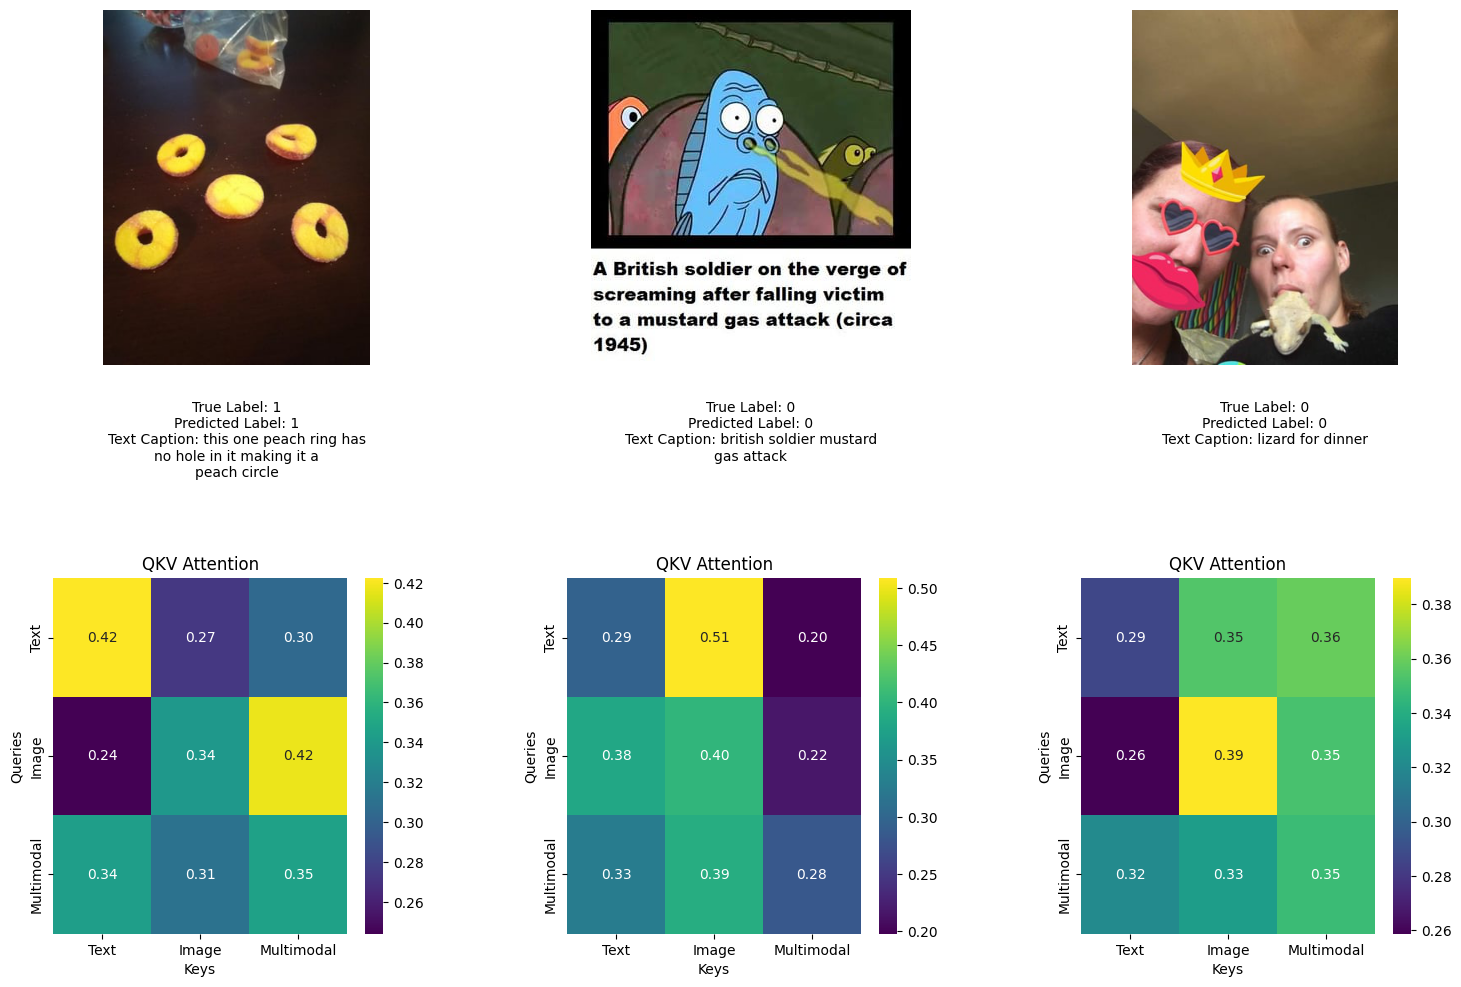

In [15]:
# FIRST SET

text_attention_array = np.load("../../../output/text_attention.npy")
image_attention_array = np.load("../../../output/image_attention.npy")
multimodal_attention_array = np.load("../../../output/multimodal_attention.npy")
predicted_labels = np.load("../../../output/test_predicted_labels.npy")
ground_truth_labels = np.load("../../../output/test_ground_truth_labels.npy")

correct_indices = np.where(
    (predicted_labels == ground_truth_labels) &
    (text_attention_array > 1.45 * image_attention_array) &
    (text_attention_array > 1.45 * multimodal_attention_array))[0]


np.random.seed(500) # ADJUST HERE

random_indices = np.random.choice(correct_indices, size=4, replace=False)
random_indices = [random_indices[0], random_indices[1], random_indices[-1]]

# Plotting loop

fig, axes = plt.subplots(2, len(random_indices), figsize=(6*len(random_indices), 12),
                         gridspec_kw={'hspace': 0.6, 'wspace': 0.4})

for i, idx in enumerate(random_indices):
    row = TEST_DATA.iloc[idx]

    text = row['clean_title']
    image_num = row['image_num']

    img_path = f"../../../test_images/{image_num}.jpg"
    image = Image.open(img_path).convert('RGB')

    label = row['2_way_label']
    predicted_label = predicted_labels[idx]
    print(f"Label = {label}, Ground Truth = {ground_truth_labels[idx]}, Predicted Label = {predicted_labels[idx]}")
    wrapped_text = "\n".join(textwrap.wrap(text, width=25))

    axes[0, i].imshow(image)
    axes[0, i].axis('off')
    axes[0, i].text(
        0.5, -0.1, f"True Label: {label}\nPredicted Label: {predicted_label}\nText Caption: {wrapped_text}",
        ha='center', va='top', transform=axes[0, i].transAxes, fontsize=10
    )

    model.eval()
    img_tensor = val_test_tfms(image).unsqueeze(0).to(device)
    text_list = [text]

    with torch.no_grad():
        logits, attn = model(text_list, img_tensor, return_attention=True)
        attn = attn[0] # Shape: (num_heads, L(Number of Queries), S (number of Keys))

    attn_avg = attn.mean(dim=0).cpu().numpy()

    tokens = ["Text", "Image", "Multimodal"]

    sns.heatmap(attn_avg, annot=True, fmt=".2f",
                xticklabels=tokens, yticklabels=tokens,
                cmap="viridis", ax=axes[1, i])

    axes[1, i].set_xlabel("Keys")
    axes[1, i].set_ylabel("Queries")
    axes[1, i].set_title("QKV Attention")

plt.tight_layout()
plt.show()


Label = 0, Ground Truth = 0, Predicted Label = 1
Label = 1, Ground Truth = 1, Predicted Label = 0
Label = 1, Ground Truth = 1, Predicted Label = 0
Label = 1, Ground Truth = 1, Predicted Label = 0


/var/folders/qj/tspvs3x90hg30hgcctblgwfh0000gn/T/ipykernel_10172/557548413.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


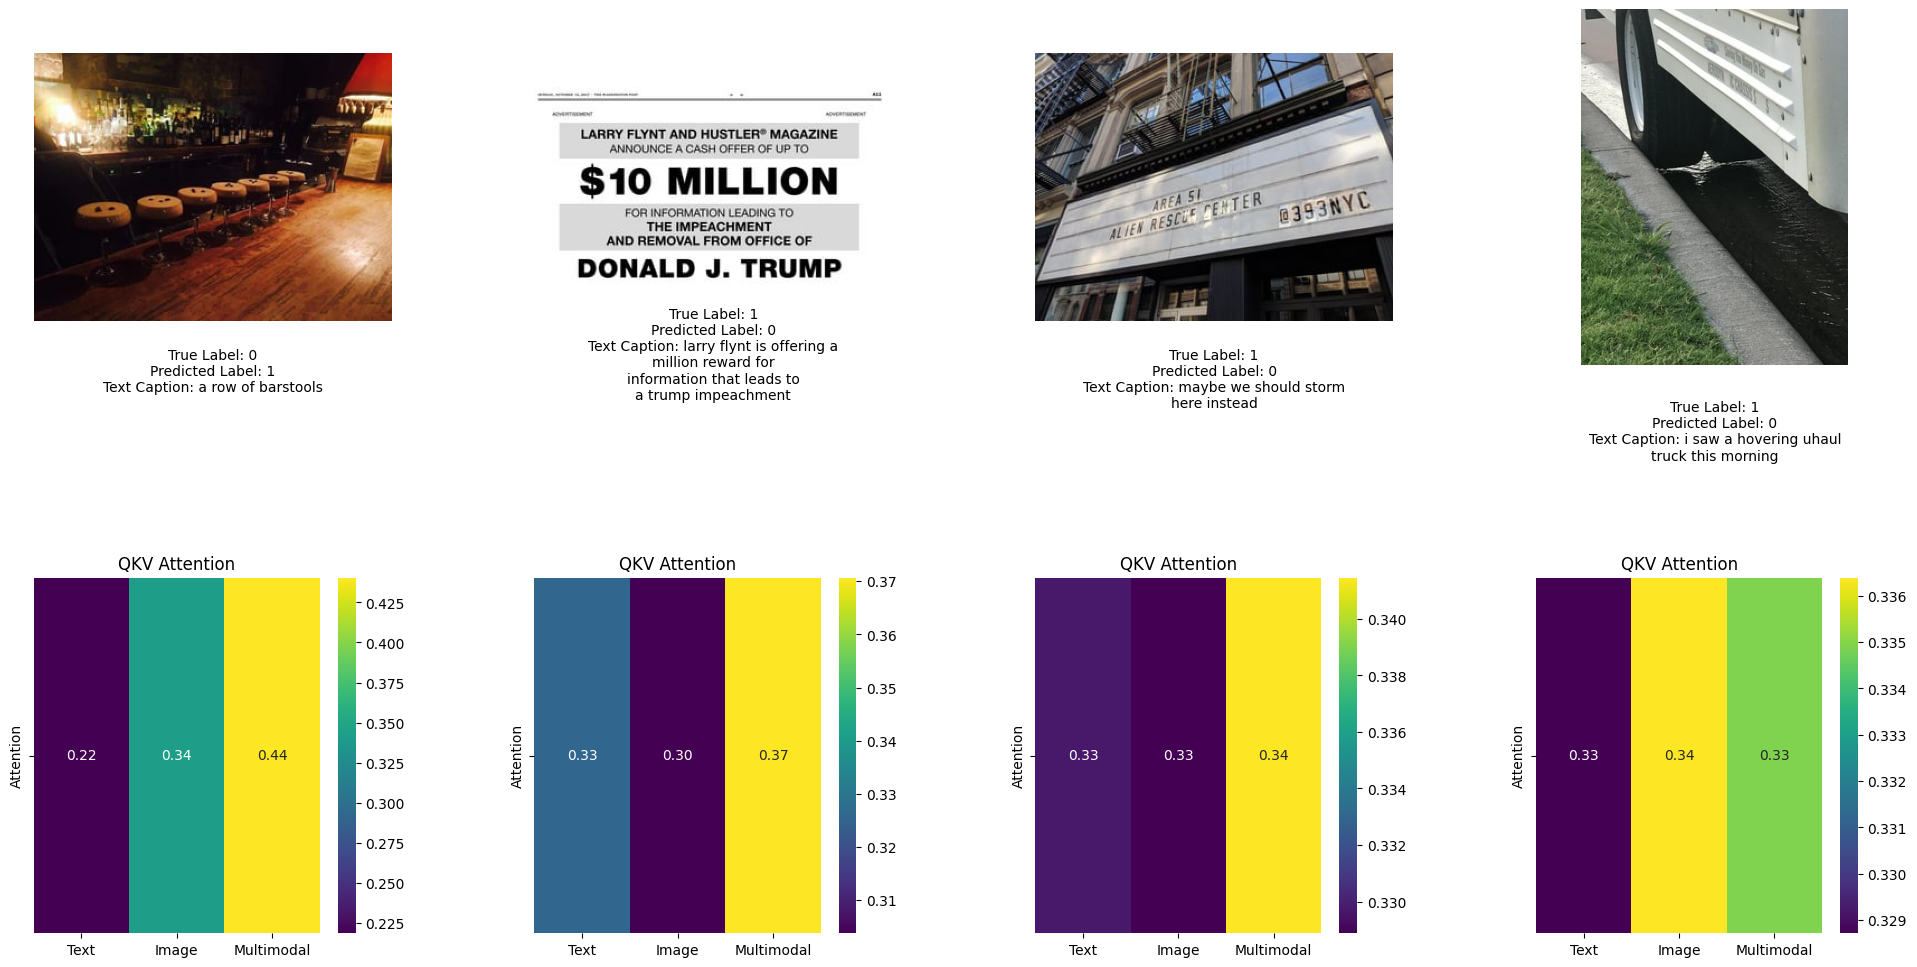

In [16]:
# FIRST SET

text_attention_array = np.load("../../../output/text_attention.npy")
image_attention_array = np.load("../../../output/image_attention.npy")
multimodal_attention_array = np.load("../../../output/multimodal_attention.npy")
predicted_labels = np.load("../../../output/test_predicted_labels.npy")
ground_truth_labels = np.load("../../../output/test_ground_truth_labels.npy")

correct_indices = np.where(
    (predicted_labels == ground_truth_labels) &
    (text_attention_array > 1.45 * image_attention_array) &
    (text_attention_array > 1.45 * multimodal_attention_array))[0]


np.random.seed(500) # ADJUST HERE

random_indices = np.random.choice(correct_indices, size=4, replace=False)
random_indices = [random_indices[0], random_indices[1], random_indices[-1]]
random_indices = np.array([1558, 4056, 4803, 3066])

# Plotting loop

fig, axes = plt.subplots(2, len(random_indices), figsize=(6*len(random_indices), 12),
                         gridspec_kw={'hspace': 0.6, 'wspace': 0.4})

for i, idx in enumerate(random_indices):
    row = TEST_DATA.iloc[idx]

    text = row['clean_title']
    image_num = row['image_num']

    img_path = f"../../../test_images/{image_num}.jpg"
    image = Image.open(img_path).convert('RGB')

    label = row['2_way_label']
    predicted_label = predicted_labels[idx]
    print(f"Label = {label}, Ground Truth = {ground_truth_labels[idx]}, Predicted Label = {predicted_labels[idx]}")
    wrapped_text = "\n".join(textwrap.wrap(text, width=25))

    axes[0, i].imshow(image)
    axes[0, i].axis('off')
    axes[0, i].text(
        0.5, -0.1, f"True Label: {label}\nPredicted Label: {predicted_label}\nText Caption: {wrapped_text}",
        ha='center', va='top', transform=axes[0, i].transAxes, fontsize=10
    )

    model.eval()
    img_tensor = val_test_tfms(image).unsqueeze(0).to(device)
    text_list = [text]

    with torch.no_grad():
        logits, attn = model(text_list, img_tensor, return_attention=True)
        attn = attn[0] # Shape: (num_heads, L(Number of Queries), S (number of Keys))

    attn_avg = attn.mean(dim=0).mean(dim = 0).cpu().numpy().reshape(1, 3)

    tokens = ["Text", "Image", "Multimodal"]

    sns.heatmap(attn_avg, annot=True, fmt=".2f",
                xticklabels=tokens, yticklabels=['Attention'],
                cmap="viridis", ax=axes[1, i])

    # axes[1, i].set_xlabel("Keys")
    # axes[1, i].set_ylabel("Queries")
    axes[1, i].set_title("QKV Attention")

plt.tight_layout()
plt.show()


Label = 0, Ground Truth = 0, Predicted Label = 0
Label = 1, Ground Truth = 1, Predicted Label = 1
Label = 1, Ground Truth = 1, Predicted Label = 1


/var/folders/qj/tspvs3x90hg30hgcctblgwfh0000gn/T/ipykernel_10172/4133154022.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


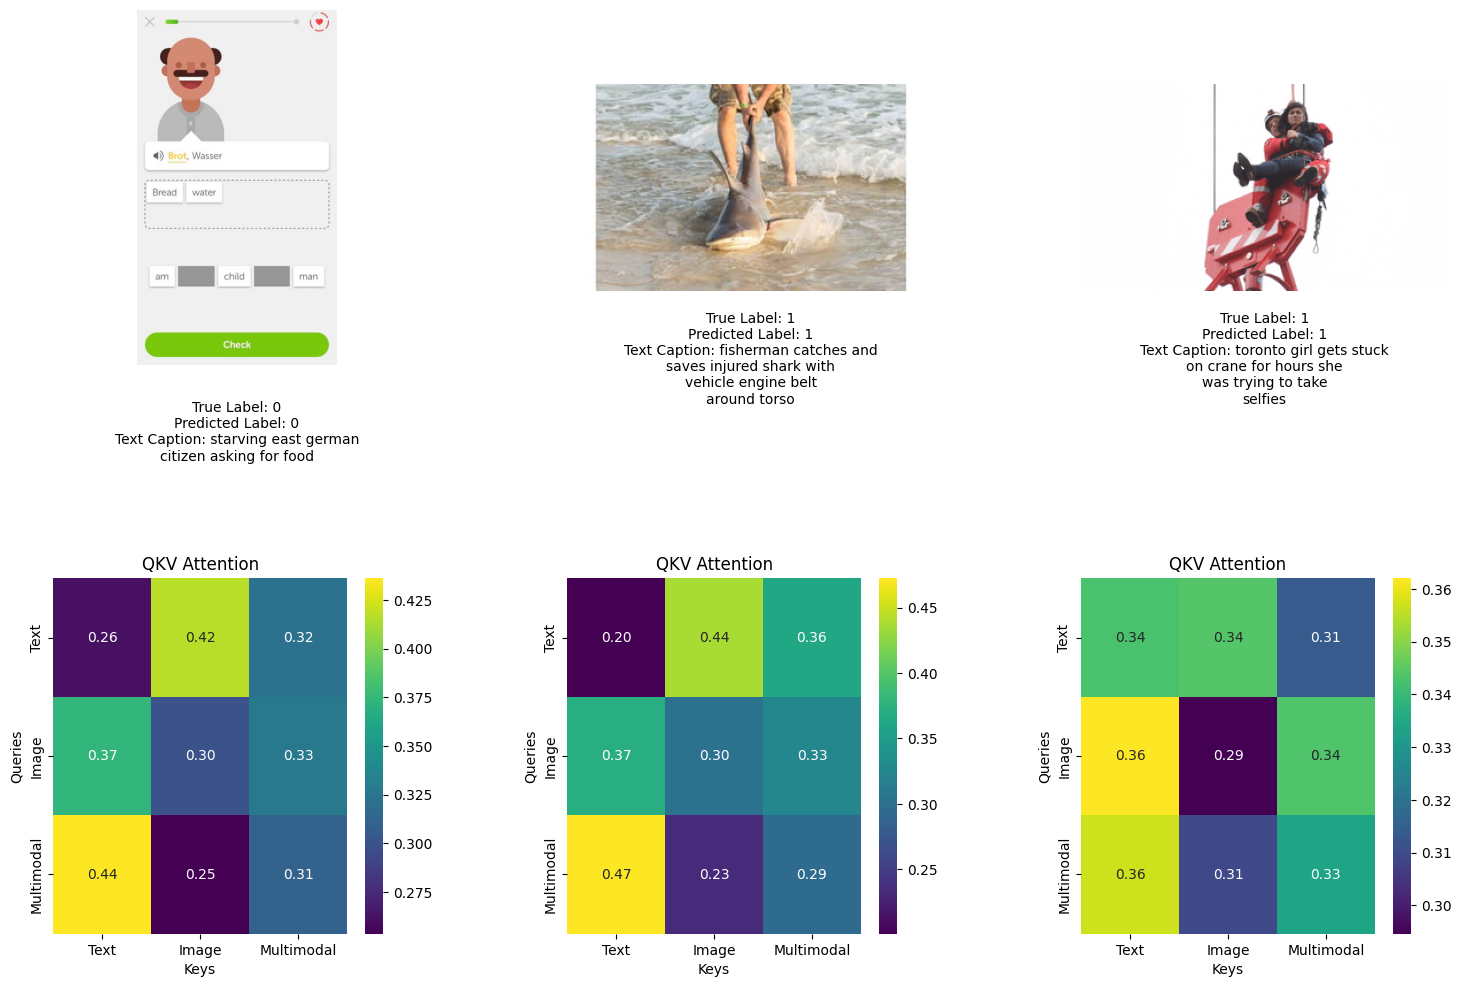

In [8]:
# SECOND SET

text_attention_array = np.load("../../../output/text_attention.npy")
image_attention_array = np.load("../../../output/image_attention.npy")
multimodal_attention_array = np.load("../../../output/multimodal_attention.npy")
predicted_labels = np.load("../../../output/test_predicted_labels.npy")
ground_truth_labels = np.load("../../../output/test_ground_truth_labels.npy")

correct_indices = np.where(
    (predicted_labels == ground_truth_labels) &
    (image_attention_array > 1.2 * text_attention_array) &
    (image_attention_array > 1.2 * multimodal_attention_array))[0]

np.random.seed(600)
random_indices = np.random.choice(correct_indices, size=4, replace=False)
random_indices = [random_indices[0], random_indices[1], random_indices[2]]

# Plotting loop

fig, axes = plt.subplots(2, len(random_indices), figsize=(6*len(random_indices), 12),
                         gridspec_kw={'hspace': 0.6, 'wspace': 0.4})

for i, idx in enumerate(random_indices):
    row = TEST_DATA.iloc[idx]

    text = row['clean_title']
    image_num = row['image_num']

    img_path = f"../../../test_images/{image_num}.jpg"
    image = Image.open(img_path).convert('RGB')

    label = row['2_way_label']
    predicted_label = predicted_labels[idx]
    print(f"Label = {label}, Ground Truth = {ground_truth_labels[idx]}, Predicted Label = {predicted_labels[idx]}")
    wrapped_text = "\n".join(textwrap.wrap(text, width=25))

    axes[0, i].imshow(image)
    axes[0, i].axis('off')
    axes[0, i].text(
        0.5, -0.1, f"True Label: {label}\nPredicted Label: {predicted_label}\nText Caption: {wrapped_text}",
        ha='center', va='top', transform=axes[0, i].transAxes, fontsize=10
    )

    model.eval()
    img_tensor = val_test_tfms(image).unsqueeze(0).to(device)
    text_list = [text]

    with torch.no_grad():
        logits, attn = model(text_list, img_tensor, return_attention=True)
        attn = attn[0] # Shape: (num_heads, L(Number of Queries), S (number of Keys))

    attn_avg = attn.mean(dim=0).cpu().numpy()

    tokens = ["Text", "Image", "Multimodal"]

    sns.heatmap(attn_avg, annot=True, fmt=".2f",
                xticklabels=tokens, yticklabels=tokens,
                cmap="viridis", ax=axes[1, i])

    axes[1, i].set_xlabel("Keys")
    axes[1, i].set_ylabel("Queries")
    axes[1, i].set_title("QKV Attention")

plt.tight_layout()
plt.show()

Label = 0, Ground Truth = 0, Predicted Label = 0
Label = 0, Ground Truth = 0, Predicted Label = 0
Label = 0, Ground Truth = 0, Predicted Label = 0


/var/folders/qj/tspvs3x90hg30hgcctblgwfh0000gn/T/ipykernel_10172/3939450333.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


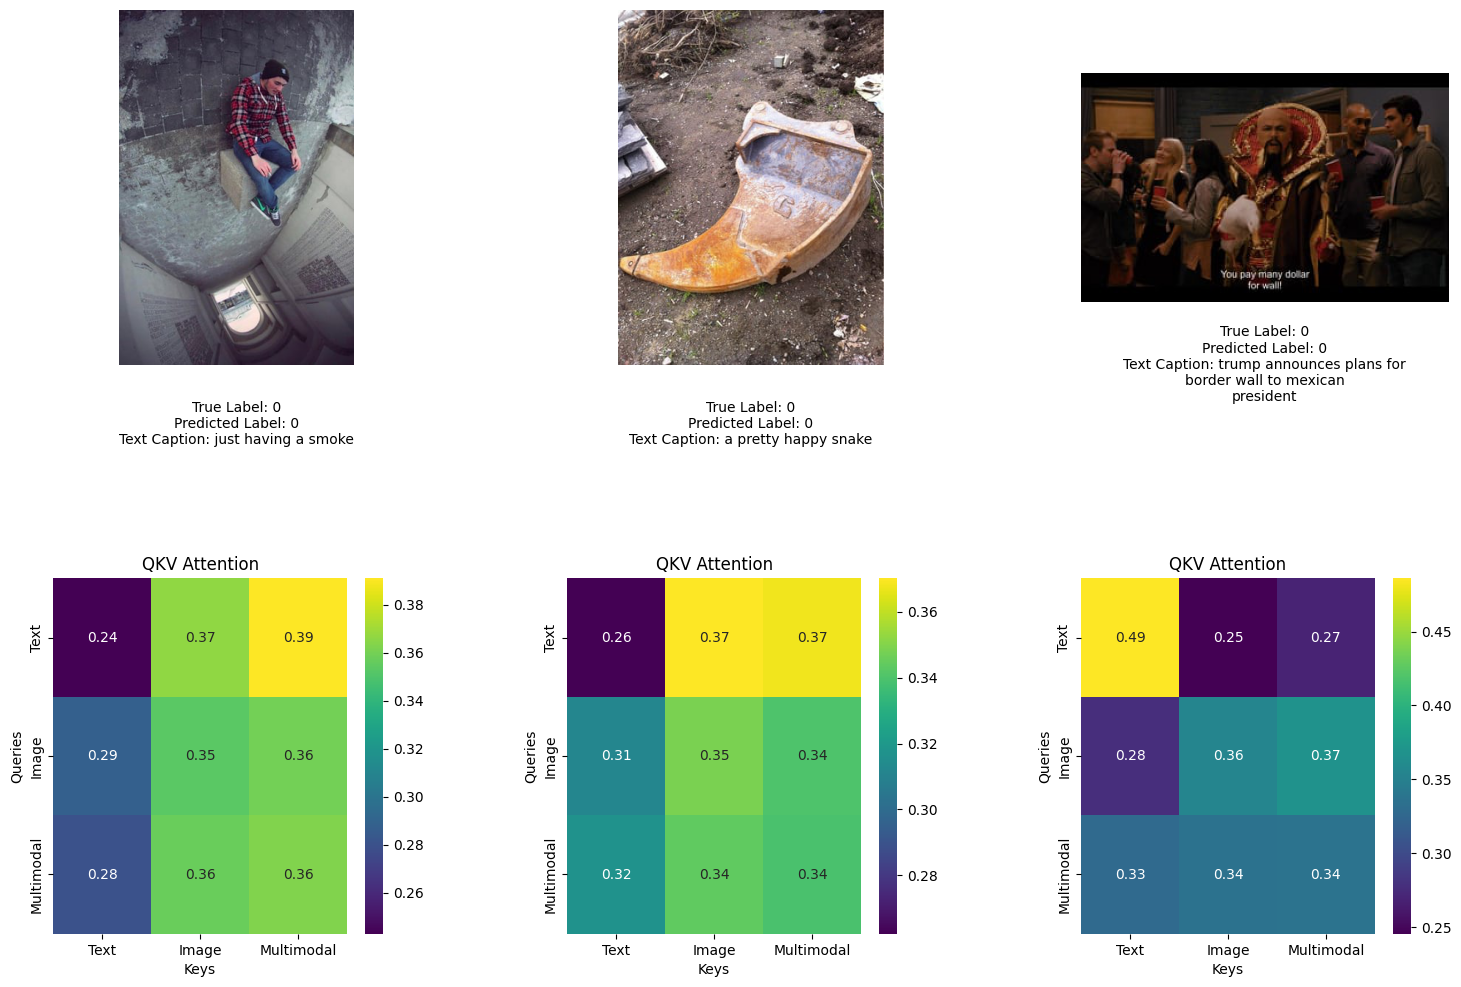

In [9]:
# THIRD SET

text_attention_array = np.load("../../../output/text_attention.npy")
image_attention_array = np.load("../../../output/image_attention.npy")
multimodal_attention_array = np.load("../../../output/multimodal_attention.npy")
predicted_labels = np.load("../../../output/test_predicted_labels.npy")
ground_truth_labels = np.load("../../../output/test_ground_truth_labels.npy")

correct_indices = np.where(
    (predicted_labels == ground_truth_labels) &
    (multimodal_attention_array > 0.9 * text_attention_array) &
    (multimodal_attention_array > 0.9 * image_attention_array))[0]

np.random.seed(600)
random_indices = np.random.choice(correct_indices, size=4, replace=False)
random_indices = [random_indices[0], random_indices[2], random_indices[-1]]

# Plotting loop

fig, axes = plt.subplots(2, len(random_indices), figsize=(6*len(random_indices), 12),
                         gridspec_kw={'hspace': 0.6, 'wspace': 0.4})

for i, idx in enumerate(random_indices):
    row = TEST_DATA.iloc[idx]

    text = row['clean_title']
    image_num = row['image_num']

    img_path = f"../../../test_images/{image_num}.jpg"
    image = Image.open(img_path).convert('RGB')

    label = row['2_way_label']
    predicted_label = predicted_labels[idx]
    print(f"Label = {label}, Ground Truth = {ground_truth_labels[idx]}, Predicted Label = {predicted_labels[idx]}")
    wrapped_text = "\n".join(textwrap.wrap(text, width=25))

    axes[0, i].imshow(image)
    axes[0, i].axis('off')
    axes[0, i].text(
        0.5, -0.1, f"True Label: {label}\nPredicted Label: {predicted_label}\nText Caption: {wrapped_text}",
        ha='center', va='top', transform=axes[0, i].transAxes, fontsize=10
    )

    model.eval()
    img_tensor = val_test_tfms(image).unsqueeze(0).to(device)
    text_list = [text]

    with torch.no_grad():
        logits, attn = model(text_list, img_tensor, return_attention=True)
        attn = attn[0] # Shape: (num_heads, L(Number of Queries), S (number of Keys))

    attn_avg = attn.mean(dim=0).cpu().numpy()

    tokens = ["Text", "Image", "Multimodal"]

    sns.heatmap(attn_avg, annot=True, fmt=".2f",
                xticklabels=tokens, yticklabels=tokens,
                cmap="viridis", ax=axes[1, i])

    axes[1, i].set_xlabel("Keys")
    axes[1, i].set_ylabel("Queries")
    axes[1, i].set_title("QKV Attention")

plt.tight_layout()
plt.show()